In [46]:
import nilearn
from nilearn.image.image import mean_img


from nilearn.masking import compute_epi_mask
from nilearn.plotting import plot_roi,plot_img


from nilearn.plotting import plot_stat_map,plot_glass_brain

import random

from nilearn.input_data import NiftiLabelsMasker # NiftiMasker


import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/homes/v20subra/.local/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:

img = '/users2/local/Venkatesh/HBN/CPAC_preprocessed/sub-NDARBK669XJQ_ses-1/functional_to_standard/_scan_rest/_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1_C-S-1+2-FD-J0.5/bandpassed_demeaned_filtered_antswarp.nii.gz'
mask = '/users2/local/Venkatesh/HBN//CPAC_preprocessed/sub-NDARBK669XJQ_ses-1/functional_brain_mask_to_standard/_scan_rest/sub-NDARBK669XJQ_task-rest_bold_calc_resample_volreg_mask_antswarp.nii.gz'
# img_to_plot = mean_img(img)


# 1. Check if "Standard" is an MNI space -- Checking the provided mask
# 2. Checking the time-series, the data distribution, voxel-level
# 3. Glasser Parcellation
# 4. The data distribution, ROI-level
# 5. Checking the significance of pre-processing


# 1. "Standard" is an MNI space ? finding it here usign mask as the ROI 

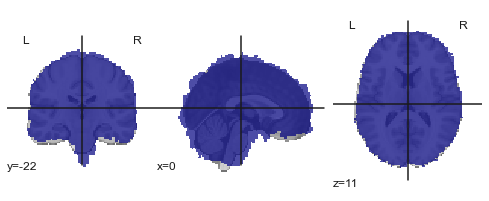

In [38]:
plot_roi(mask)

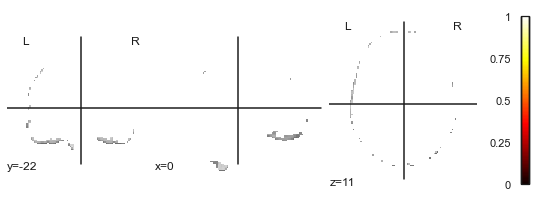

In [39]:

plot_stat_map(mask)

# Loading data voxel-level 

(array([  2.,   5.,  10.,  51.,  72., 117.,  94.,  49.,  12.,   8.]),
 array([-262.63730947, -215.2959209 , -167.95453232, -120.61314375,
         -73.27175517,  -25.9303666 ,   21.41102198,   68.75241055,
         116.09379912,  163.4351877 ,  210.77657627]),
 <BarContainer object of 10 artists>)

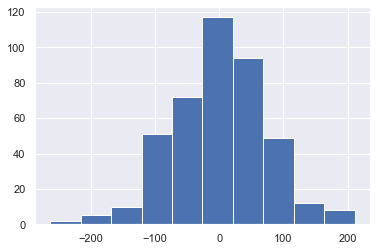

In [40]:
img_voxels = nilearn.input_data.NiftiMasker(mask).fit_transform(img)

plt.hist(img_voxels[:,random.randint(1,236454)])

# 3. Glasser Parcellation

In [47]:
# import yaml

# loc_for_pipeline = '/users2/local/Venkatesh/HBN/CPAC_preprocessed/pipeline.yml'
# with open(loc_for_pipeline, "r") as stream:
#             print(yaml.safe_load(stream))


path_Glasser = '/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz'


def parcellation(mask,img):
    # Glasser is a reference map for regions in the brain. It splits the brain into 360 regions.
    glassermasker = NiftiLabelsMasker(labels_img=path_Glasser,mask_img=mask,standardize=True)
    parcellated = glassermasker.fit_transform(img)
    return parcellated

# 4. The distribution at ROI-level

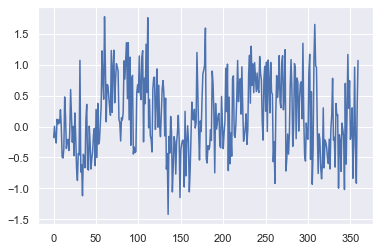

In [6]:
plt.plot(parcellated[0,:])

(array([11., 17., 39., 68., 85., 94., 63., 31.,  9.,  3.]),
 array([-2.66447115, -2.10617888, -1.54788661, -0.98959433, -0.43130206,
         0.12699021,  0.68528248,  1.24357475,  1.80186702,  2.3601593 ,
         2.91845157]),
 <BarContainer object of 10 artists>)

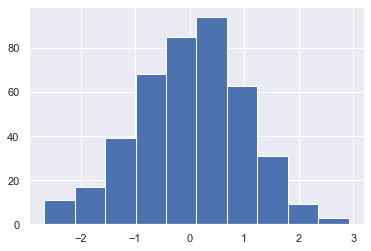

In [8]:

plt.hist((parcellated[:,random.randint(1,359)]))

In [48]:
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from nilearn import plotting
def connectivitymeasure(which_subject_after_parcellation):
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([which_subject_after_parcellation])[0]# 25 indiv 


    #for later: tangent group-level
    #


    np.fill_diagonal(correlation_matrix, 0)

    return correlation_matrix
rois = np.load('/homes/v20subra/S4B2/GSP/hcp/regions.npy')
roi_labels = [rois[i][1] for i in range(360)]

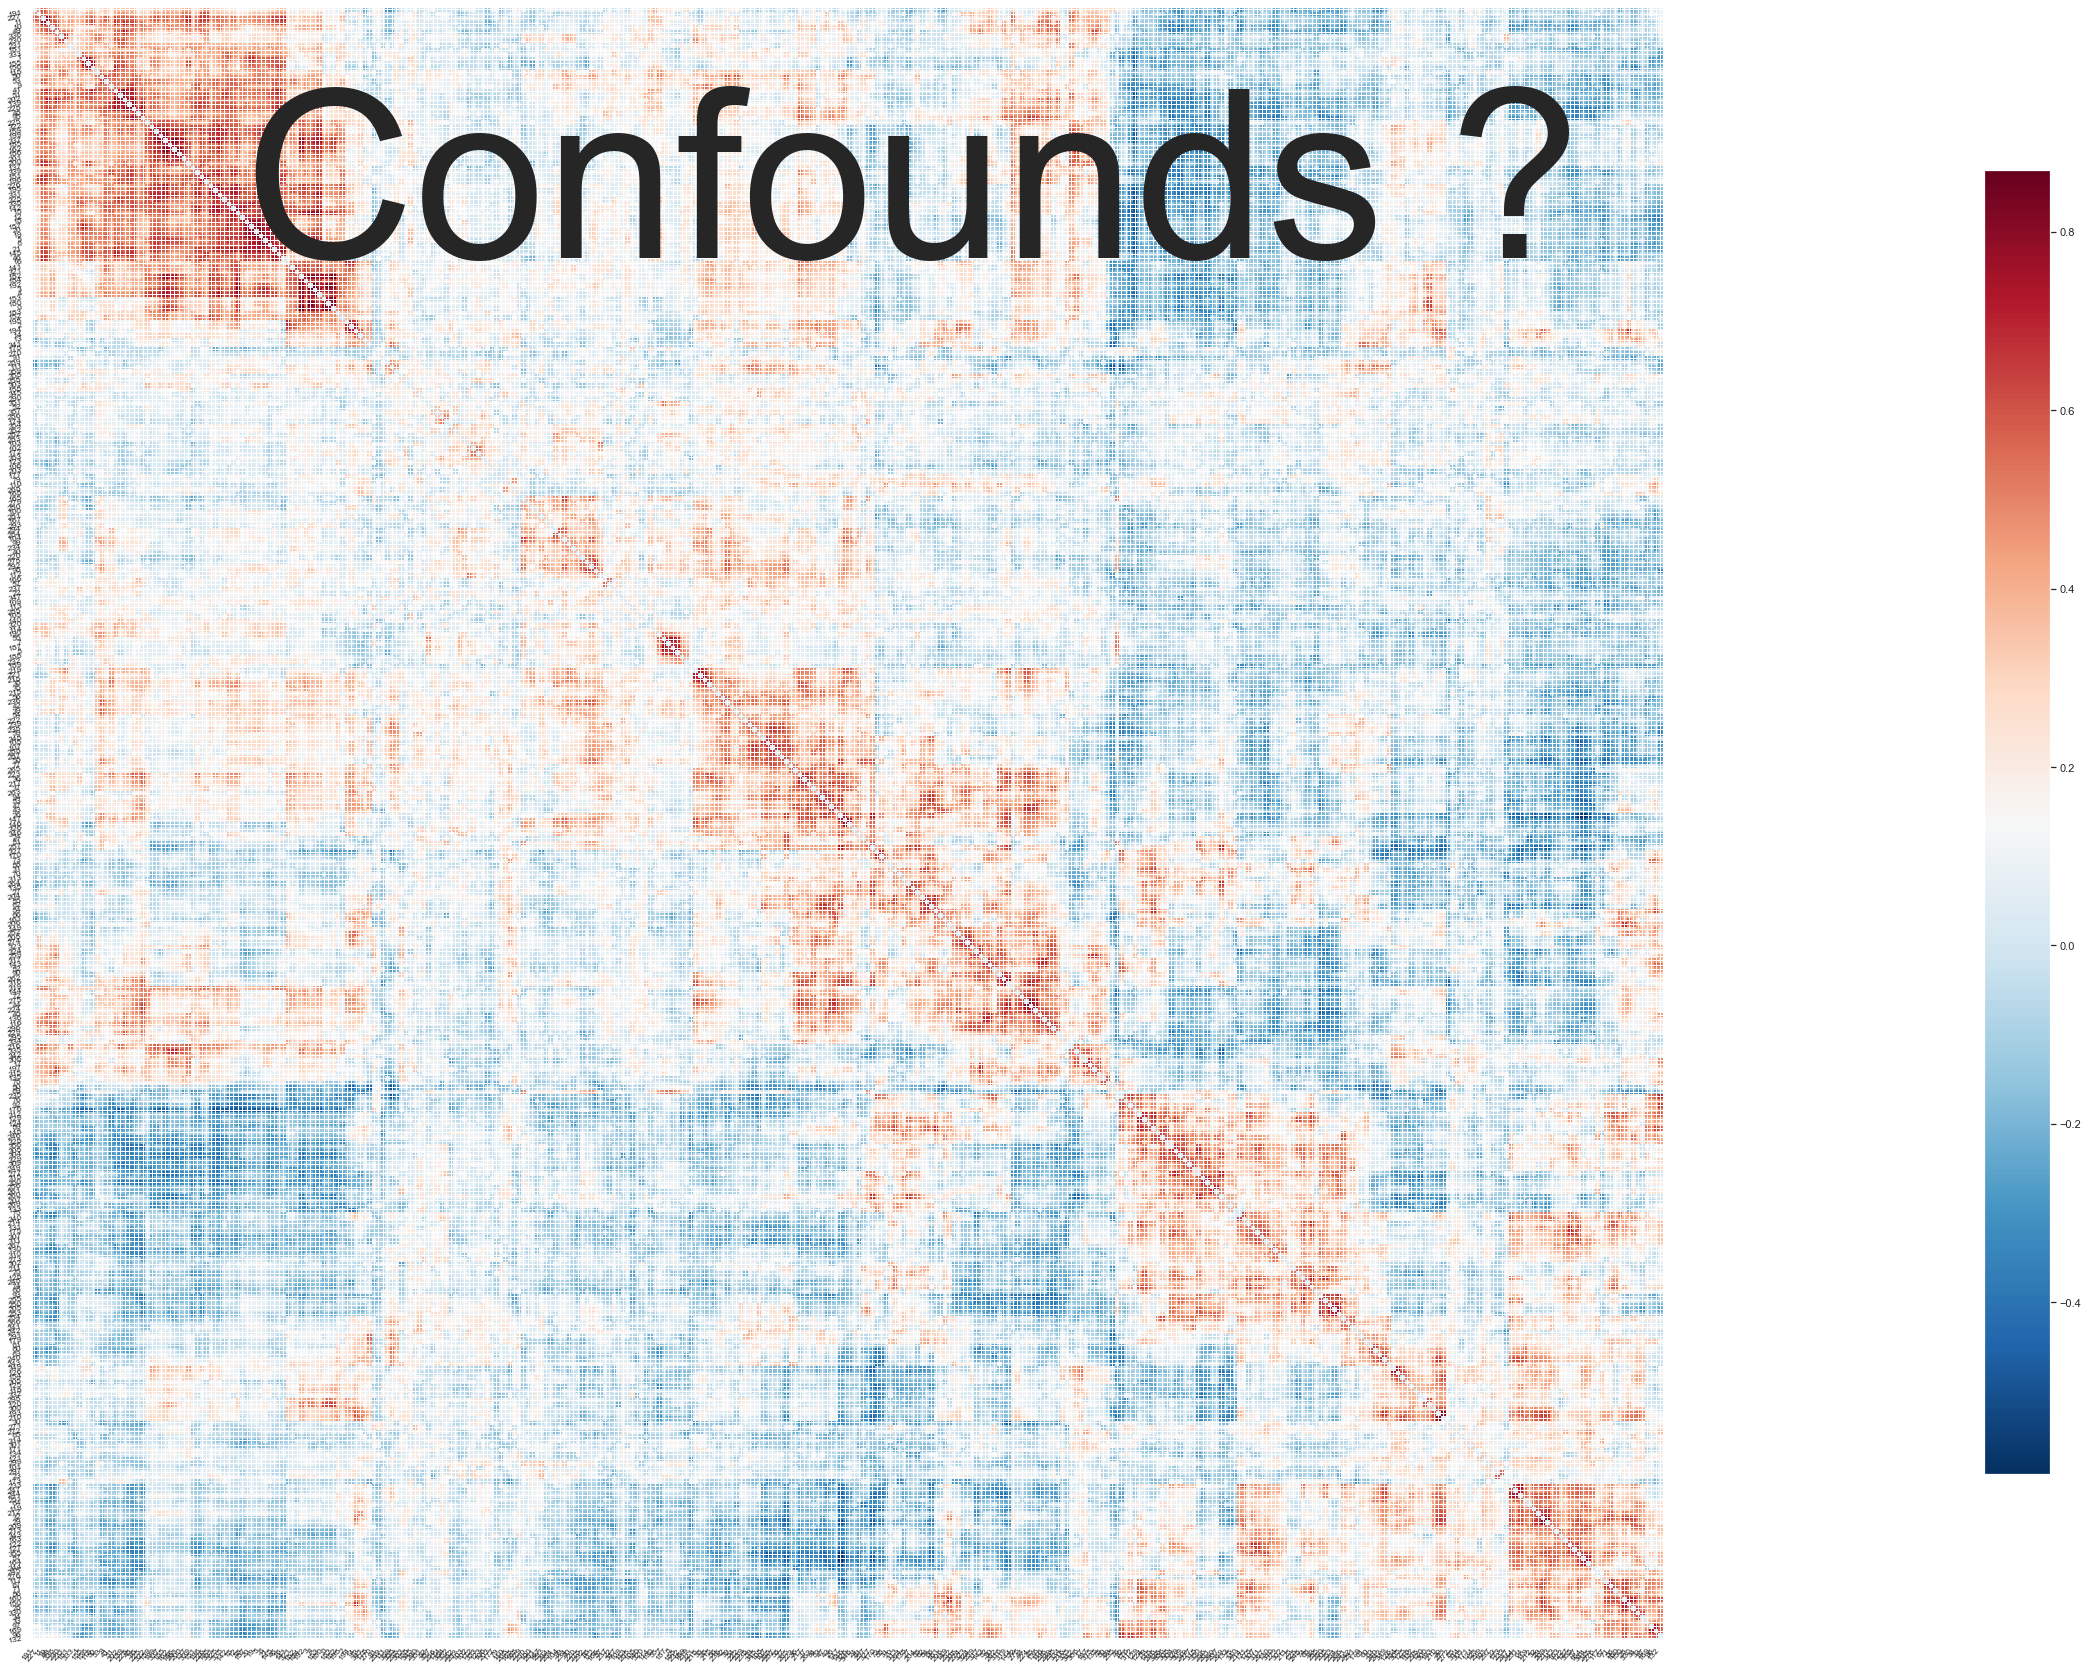

In [43]:
l = np.arange(360)
plotting.plot_matrix(correlation_matrix, figure=(55, 30), labels=l, title="Confounds ?",
                     reorder=True)
                     #nilearn tuto for neigh voxels -correlation --
                     #seed-based
                     #niftisphere masker

                     

# Code for 8-NN findings

In [49]:
import pickle
import torch


# pickle_file = '/homes/v20subra/S4B2/GSP/MMP_RSFC_brain_graph_fullgraph.pkl'

# with open(pickle_file, 'rb') as f:
#         [connectivity]= pickle.load(f)
# connectivity.shape
def NNgraph(correlation_matrix,is_consensus=False):
    
    connectivity = correlation_matrix
    np.fill_diagonal(connectivity,0)
    if is_consensus:
        pickle_file = '/homes/v20subra/S4B2/GSP/MMP_RSFC_brain_graph_fullgraph.pkl'

        with open(pickle_file, 'rb') as f:
                [connectivity]= pickle.load(f)
        np.fill_diagonal(connectivity,0)

    graph = torch.from_numpy(connectivity)
    knn_graph = torch.zeros(graph.shape)
    for i in range(knn_graph.shape[0]):
        graph[i,i] = 0
        best_k = torch.sort(graph[i,:])[1][-8:]
        knn_graph[i, best_k] = 1
        knn_graph[best_k, i] = 1
        
    degree = torch.diag(torch.pow(knn_graph.sum(dim = 0), -0.5))
    # laplacian = torch.eye(graph.shape[0]) - torch.matmul(degree, torch.matmul(knn_graph, degree))
    # values, eigs = torch.linalg.eigh(laplacian)

    weight_matrix_after_NN = torch.matmul(degree, torch.matmul(knn_graph, degree))
    return weight_matrix_after_NN,knn_graph

In [50]:
from scipy import io as sio
from pygsp import graphs
from seaborn.utils import axis_ticklabels_overlap
from scipy.sparse import csr_matrix

def graph_setup(laplacian,weight_matrix_after_NN):
    path_Glasser='/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz'
    res_path=''
    coordinates = sio.loadmat('/homes/v20subra/S4B2/GSP/Glasser360_2mm_codebook.mat')['codeBook'] 

    # Load structural connectivity matrix
    # connectivity = sio.loadmat('/homes/v20subra/S4B2/GSP/SC_avg56.mat')['SC_avg56']
    pickle_file = '/homes/v20subra/S4B2/GSP/MMP_RSFC_brain_graph_fullgraph.pkl'

    G=graphs.Graph(weight_matrix_after_NN,gtype='HCP subject',lap_type=laplacian,coords=coordinates) 
    G.set_coordinates('spring')
    print('{} nodes, {} edges'.format(G.N, G.Ne))
    try:
        G.compute_fourier_basis()

    finally:
    
        return G

# G = graph_setup(laplacian='normalized')

# ###############################
# ####Decomposing into eigenmodes
# ###############################
# G.compute_fourier_basis()

# Eigenvalues

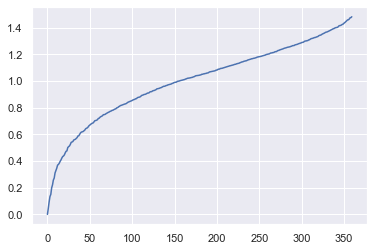

In [21]:
plt.plot(G.e)

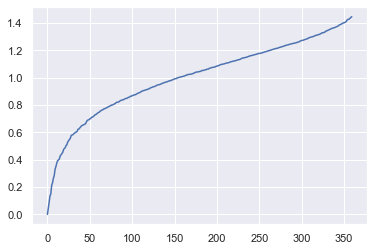

In [20]:
plt.plot(values.numpy())

In [37]:
np.where(np.array(roi_labels)=='Default')

(array([ 11,  24,  25,  27,  73,  74,  78,  80, 122, 124, 127, 128, 138,
        171, 191, 205, 254, 258, 302, 304, 308, 318, 351]),)

# 

# Eigenvector for the subject-specific & consensus graph
# ISC of Degree
# Noise floor :(

In [98]:
path_Glasser = '/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz'

from nilearn.regions import signals_to_img_labels  
# load nilearn label masker for inverse transform
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting
from nilearn import datasets
from os.path import join as opj
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os


subjects = ['NDARAD481FXF','NDARBK669XJQ',
'NDARCD401HGZ','NDARDX770PJK',
'NDAREC182WW2','NDARGY054ENV',
'NDARHP176DPE','NDARLB017MBJ',
'NDARMR242UKQ','NDARNT042GRA',
'NDARRA733VWX','NDARRD720XZK',
'NDARTR840XP1','NDARUJ646APQ',
'NDARVN646NZP','NDARWJ087HKJ',
'NDARXB704HFD','NDARXJ468UGL',
'NDARXJ696AMX','NDARXU679ZE8',
'NDARXY337ZH9','NDARYM257RR6',
'NDARYY218AGA','NDARYZ408VWW','NDARZB377WZJ']

subjects_data_available_for =list()

for i in range(1,25):
     if (os.path.isfile(f'/users2/local/Venkatesh/HBN/CPAC_preprocessed/sub-{subjects[i]}_ses-1/functional_to_standard/_scan_rest/_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1_C-S-1+2-FD-J0.5/bandpassed_demeaned_filtered_antswarp.nii.gz')):
         subjects_data_available_for.append(subjects[i])
         

mnitemp = fetch_icbm152_2009()
mask_mni=image.load_img(mnitemp['mask'])
glasser_atlas=image.load_img(path_Glasser)


subjects_data_available_for =list()

for i in range(1,25):
     if (os.path.isfile(f'/users2/local/Venkatesh/HBN/CPAC_preprocessed/sub-{subjects[i]}_ses-1/functional_to_standard/_scan_rest/_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1_C-S-1+2-FD-J0.5/bandpassed_demeaned_filtered_antswarp.nii.gz')):
         subjects_data_available_for.append(subjects[i])

for i in range(1,len(subjects_data_available_for)):
    if not os.path.exists(f"/homes/v20subra/S4B2/Graph-related_analysis/Functional_graph_setup/Results_/{subjects_data_available_for[i]}"):
        
        # if the demo_folder directory is not present
        # then create it.
        os.makedirs(f"/homes/v20subra/S4B2/Graph-related_analysis/Functional_graph_setup/Results_/{subjects_data_available_for[i]}")




def main(subj,is_consensus,subject_no):
    img = f'/users2/local/Venkatesh/HBN/CPAC_preprocessed/sub-{subj}_ses-1/functional_to_standard/_scan_rest/_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1_C-S-1+2-FD-J0.5/bandpassed_demeaned_filtered_antswarp.nii.gz'
    mask = f'/users2/local/Venkatesh/HBN/CPAC_preprocessed/sub-{subj}_ses-1/functional_brain_mask_to_standard/_scan_rest/sub-{subj}_task-rest_bold_calc_resample_volreg_mask_antswarp.nii.gz'
    # print('running parcellation')
    parcellated = parcellation(mask,img)

    # print('running correlation_matrix')
    correlation_matrix = connectivitymeasure(parcellated)


    # print('running weight_matrix_after_NN')
    weight_matrix_after_NN,knn_graph = NNgraph(correlation_matrix,is_consensus)
    np.fill_diagonal(weight_matrix_after_NN.numpy(),0)
    # G = graph_setup('normalized',weight_matrix_after_NN)

    # for i in range(1,4):
    #     signal=np.expand_dims(G.U[:,i], axis=0) # add dimension 1 to signal array

    #     U0_brain = signals_to_img_labels(signal,path_Glasser,mnitemp['mask'])
    #     nilearn.plotting.plot_img_on_surf(U0_brain,
    #                             views=['lateral','medial'],
    #                             hemispheres=['left'],
    #                             colorbar=True,
    #     output_file ='/homes/v20subra/S4B2/Graph-related_analysis/Functional_graph_setup/Results_/{}/eigenvector{}.png'.format(subject_no,i))
    return  knn_graph,weight_matrix_after_NN

# weight_matrix_after_NN = main(subj = subjects[21],is_consensus=True,subject_no='consensus')
knn_graph,weight_matrix_after_NN = dict(),dict()
for j in tqdm(range(1,len(subjects_data_available_for))):
   knn_graph[j],weight_matrix_after_NN[j]= main(subj = subjects_data_available_for[j-1],is_consensus=False,subject_no=j)


  0%|          | 0/20 [00:00<?, ?it/s]

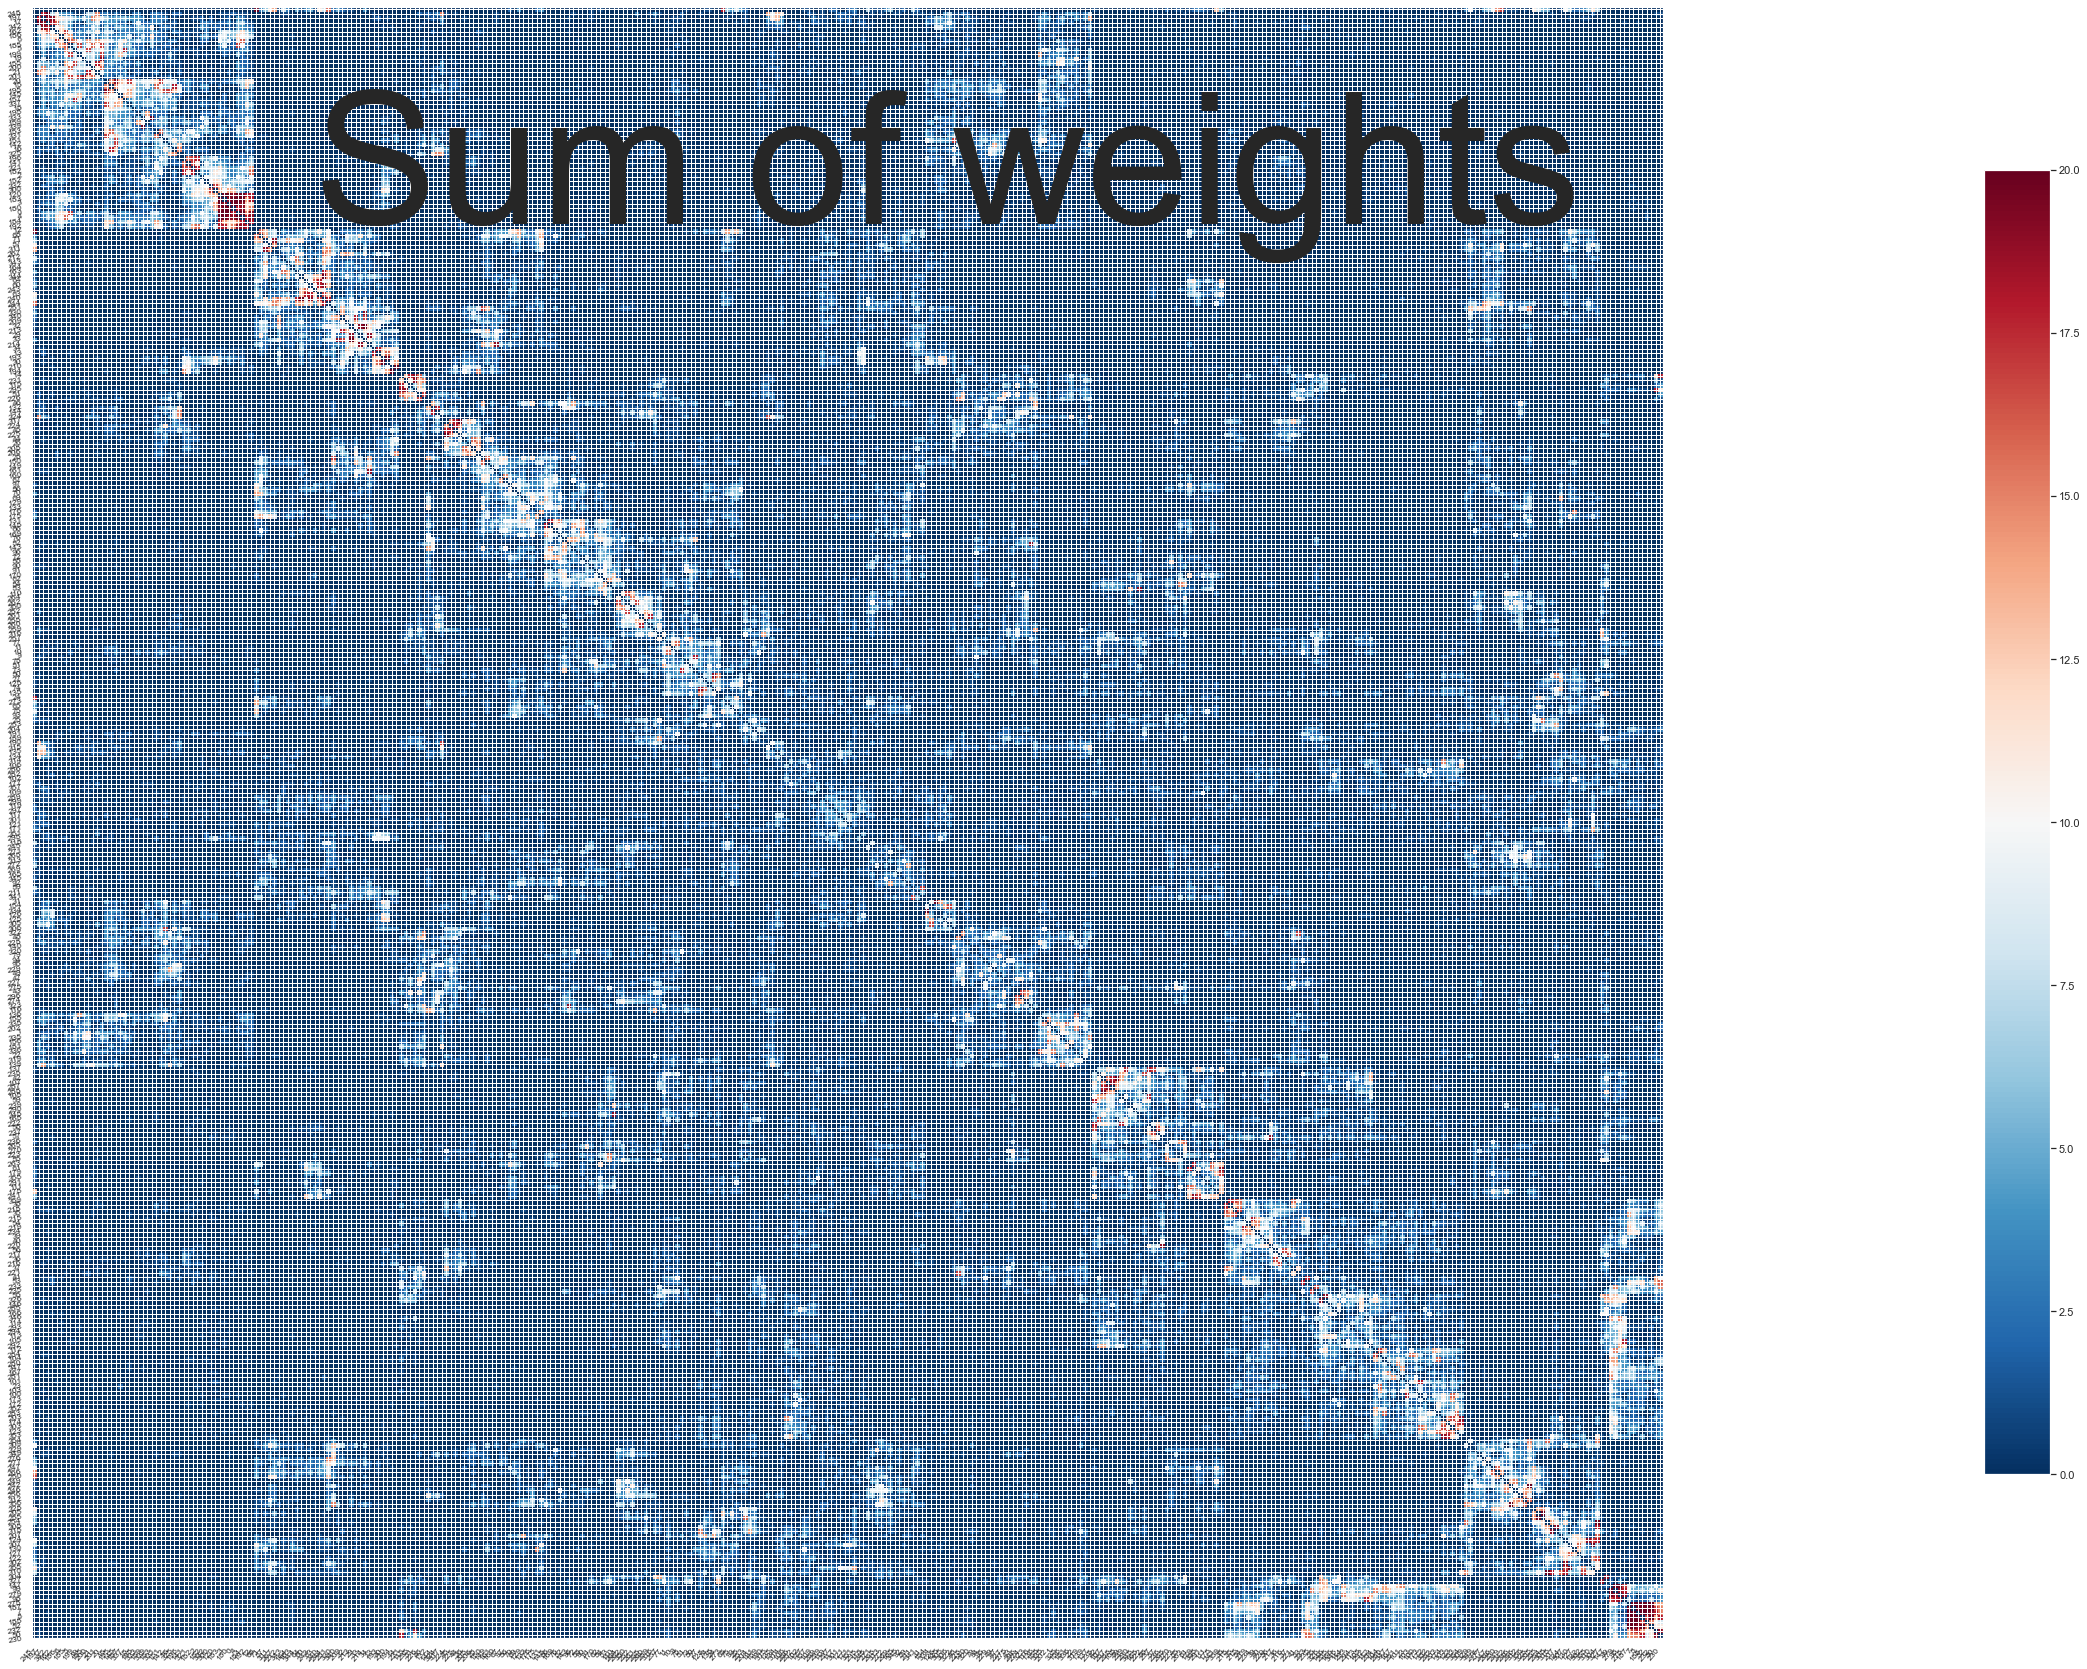

In [105]:
l = np.arange(360)

plotting.plot_matrix(sum(knn_graph.values()).numpy(), figure=(55, 30), labels=l, title="Sum of weights",reorder=True)

array([[0.  , 0.  , 0.15, ..., 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.05, ..., 0.  , 0.  , 0.  ],
       [0.15, 0.05, 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.05, 0.  , 0.  , ..., 0.05, 0.05, 0.05],
       [0.  , 0.  , 0.  , ..., 0.05, 0.  , 0.85],
       [0.  , 0.  , 0.  , ..., 0.05, 0.85, 0.  ]], dtype=float32)

In [156]:
vals = np.sum(np.stack([*weight_matrix_after_NN.values()]),axis=0)

l = np.linalg.eigh(vals)
for i in range(1,4):
    signal=np.expand_dims(l[1][i], axis=0) # add dimension 1 to signal array

    U0_brain = signals_to_img_labels(signal,path_Glasser,mnitemp['mask'])
    nilearn.plotting.plot_img_on_surf(U0_brain,
                        views=['lateral','medial'],
                        hemispheres=['left'],
                        colorbar=True,output_file=f'/homes/v20subra/S4B2/Graph-related_analysis/Functional_graph_setup/Results_consensus_20_subjects_unbinarized/eigvector{i}')

In [46]:
subjects_data_available_for =list()

for i in range(1,25):
     if (os.path.isfile(f'/users2/local/Venkatesh/HBN/CPAC_preprocessed/sub-{subjects[i]}_ses-1/functional_to_standard/_scan_rest/_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1_C-S-1+2-FD-J0.5/bandpassed_demeaned_filtered_antswarp.nii.gz')):
         subjects_data_available_for.append(subjects[i])
         
print(sorted(subjects_data_available_for))
print((subjects_data_available_for))

['NDARBK669XJQ', 'NDARCD401HGZ', 'NDARDX770PJK', 'NDAREC182WW2', 'NDARGY054ENV', 'NDARHP176DPE', 'NDARMR242UKQ', 'NDARNT042GRA', 'NDARRD720XZK', 'NDARTR840XP1', 'NDARUJ646APQ', 'NDARVN646NZP', 'NDARWJ087HKJ', 'NDARXJ468UGL', 'NDARXJ696AMX', 'NDARXU679ZE8', 'NDARXY337ZH9', 'NDARYM257RR6', 'NDARYY218AGA', 'NDARYZ408VWW', 'NDARZB377WZJ']
['NDARBK669XJQ', 'NDARCD401HGZ', 'NDARDX770PJK', 'NDAREC182WW2', 'NDARGY054ENV', 'NDARHP176DPE', 'NDARMR242UKQ', 'NDARNT042GRA', 'NDARRD720XZK', 'NDARTR840XP1', 'NDARUJ646APQ', 'NDARVN646NZP', 'NDARWJ087HKJ', 'NDARXJ468UGL', 'NDARXJ696AMX', 'NDARXU679ZE8', 'NDARXY337ZH9', 'NDARYM257RR6', 'NDARYY218AGA', 'NDARYZ408VWW', 'NDARZB377WZJ']


In [ ]:
os.makedirs('')

In [37]:
import numpy as np
smoothness = np.load('/users2/local/Venkatesh/Generated_Data/25_subjects_copy_FOR_TESTING/smoothness_time_series.npz')['smoothness_time_series']
smoothness_squeezed = np.squeeze(smoothness)

In [38]:
to_append = list()
for i in range(0,len(smoothness_squeezed),125):
            to_append.append(np.average(smoothness_squeezed[i:i+125,:],axis=0))


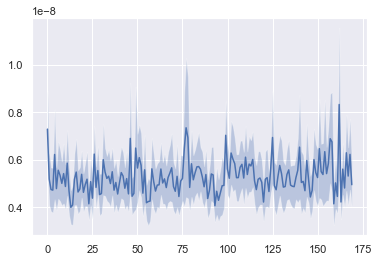

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_theme()

to_plot = np.average(to_append,axis=1)

sem = scipy.stats.sem(to_append,axis=1)


plt.plot(to_plot)
plt.fill_between(range(170),to_plot-sem,to_plot+sem, alpha=.3)


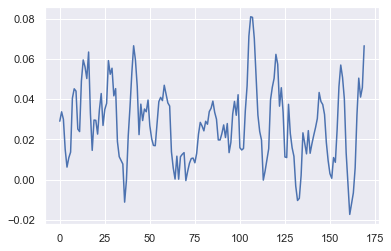

In [42]:
isc_result = np.load('/users2/local/Venkatesh/Generated_Data/25_subjects/sourceCCA_ISC.npz')['sourceISC']

plt.plot(isc_result[0])

In [49]:
significance = np.array(np.where(np.max(np.array(noise_floor_source)[:,:2,:],axis=0)<isc_result[0:2]))
significance[1]


array([  7,   8,  13,  14,  15,  16,  27,  28,  29,  40,  41,  42,  43,
        58,  85,  99, 104, 105, 106, 107, 108, 109, 118, 119, 120, 121,
       123, 127, 144, 146, 155, 156, 157,   6,   7,   8,  11,  12,  13,
        14,  15,  18,  46,  47,  48,  49,  50,  53,  56,  57,  59,  60,
        68, 102, 103, 104, 105, 106, 107, 111, 112, 114, 145, 146, 159,
       160, 163, 165, 166, 169])

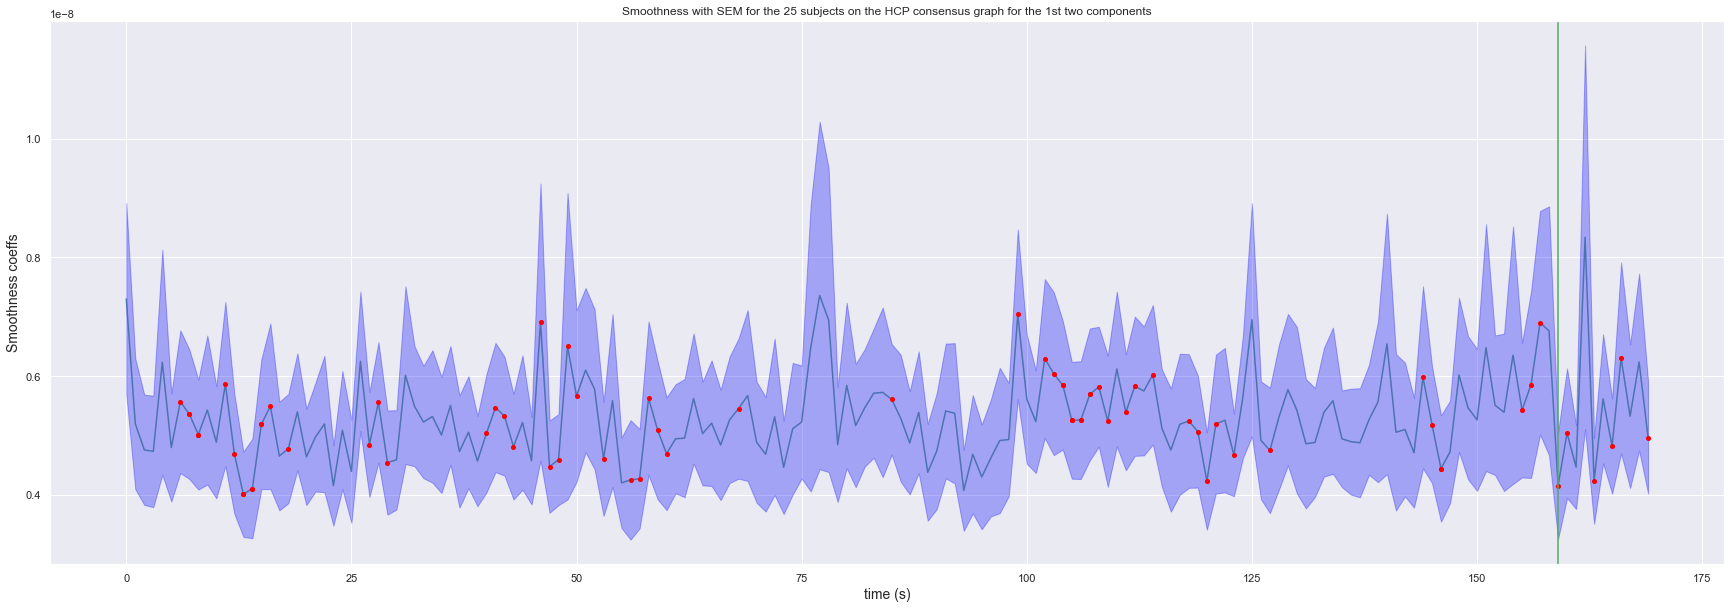

In [50]:
# create figure and axis objects with subplots()
import numpy as np
import matplotlib.pyplot as plt
noise_floor_source = np.load('/users2/local/Venkatesh/Generated_Data/25_subjects/noise_floor_source.npz')['sourceCCA']

# significance = np.array(np.where(np.max(np.array(noise_floor_source)[:,0,:],axis=0)<isc_result[0]))

def drawingline(axes):
        
   
        axes.axvspan(0,4,alpha=0.1, color='C1')
        axes.axvspan(33,36,alpha=0.1, color='C1')
        axes.axvspan(49,53,alpha=0.1, color='C1')

        axes.axvspan(62,65,alpha=0.1, color='C1')
        axes.axvspan(88,94,alpha=0.1, color='C1')
        axes.axvspan(129,132,alpha=0.1, color='C1')
        axes.axvspan(148,152,alpha=0.1, color='C1')

        axes.axvspan(7,8,alpha=0.1, color='C0')
        axes.axvspan(13,16,alpha=0.1, color='C0')
        axes.axvspan(27,29,alpha=0.1, color='C0')
        axes.axvspan(40,43,alpha=0.1, color='C0')
        axes.axvspan(118,123,alpha=0.1, color='C0')
        axes.axvspan(104,109,alpha=0.1, color='C0')
        axes.axvspan(155,157,alpha=0.1, color='C0')

fig,ax = plt.subplots(figsize=(30,10))


ax.plot(to_plot)
ax.fill_between(range(170),to_plot-sem,to_plot+sem, alpha=.3,color='blue')
# ax.plot(gapminder_us.year, gapminder_us.lifeExp, color="red", marker="o")
# set x-axis label
ax.set_xlabel("time (s)",fontsize=14)
# set y-axis label
ax.set_ylabel("Smoothness coeffs",fontsize=14)
ax.plot(significance[1],to_plot[significance[1]],
                marker='o', ls="",color='red',markersize=4)


# twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.plot(isc_result[0],color='green')
# ax2.set_ylabel("ISC Coefficients",color="green",fontsize=14)
ax.axvline(x=159,color='g')
plt.title('Smoothness with SEM for the 25 subjects on the HCP consensus graph for the 1st two components')
plt.show()


In [30]:

import pandas as pd

eyetracking = pd.read_csv('/users2/local/Venkatesh/HBN/NDARDX770PJK/Eyetracking/txt/NDARDX770PJK_Video-DM_Samples.txt',sep='\n')

    # lines = [line.rstrip('\t|\n') for line in f]

In [33]:
eyetracking[:45].values

array([['Converted from: NA'],
       ['Date: NA'],
       ['## Version:\tIDF Converter 3.0.16'],
       ['## IDF Version:\t9'],
       ['## Sample Rate:\t120'],
       ['## Separator Type:\tUnknown'],
       ['## Trial Count:\t1'],
       ['## Uses Plane File:\tFalse'],
       ['## Number of Samples:\t20976                                                                                                                                                                                                                                                           '],
       ['## Reversed:\tnone'],
       ['## [Run]'],
       ['Subject: NA'],
       ['## Description:\t                                                                                                                                                                                                                                                                '],
       ['## [Calibration]'],
       ['## Calibration Type:\t5-point'],
   

In [40]:
# pd.read_csv('/users2/local/Venkatesh/HBN/NDARDX770PJK/Video3_event.csv')



,type,sample,value,offset,duration,timestamp,orig
0,9999,1,NaN,NaN,1,NaN,NaN
1,83,2163,NaN,NaN,1,NaN,NaN
2,103,87438,NaN,NaN,1,NaN,NaN


In [17]:
a=['Time\tType\tTrial\tL Dia X [px]\tL Dia Y [px]\tR Dia X [px]\tR Dia Y [px]\tL POR X [px]\tL POR Y [px]\tR POR X [px]\tR POR Y [px]\tTiming\tLatency\tL Validity\tR Validity\tPupil Confidence\tL Plane\tR Plane\tH POS X [mm]\tH POS Y [mm]\tH POS Z [mm]\tH ROT X [°]\tH ROT Y [°]\tH ROT Z [°]\tL EPOS X\tL EPOS Y\tL EPOS Z\tR EPOS X\tR EPOS Y\tR EPOS Z\tL GVEC X\tL GVEC Y\tL GVEC Z\tR GVEC X\tR GVEC Y\tR GVEC Z\tFrame\tAux1',
'19444614055\tMSG\t1\t# UTC: 1471031900 546',
       '19444614173\tSMP\t1\t14.30\t14.30\t15.02\t15.02\t485.87\t426.64\t485.87\t426.64\t0\t1791\t0\t0\t3\t1\t1\t0.00\t0.00\t0.00\t0.00\t0.00\t0.00\t-60.11\t32.42\t692.66\t-1.60\t28.91\t708.82\t0.15\t0.14\t-0.98\t0.04\t0.20\t-0.98\t\t']

[['Time',
  'Type',
  'Trial',
  'L Dia X [px]',
  'L Dia Y [px]',
  'R Dia X [px]',
  'R Dia Y [px]',
  'L POR X [px]',
  'L POR Y [px]',
  'R POR X [px]',
  'R POR Y [px]',
  'Timing',
  'Latency',
  'L Validity',
  'R Validity',
  'Pupil Confidence',
  'L Plane',
  'R Plane',
  'H POS X [mm]',
  'H POS Y [mm]',
  'H POS Z [mm]',
  'H ROT X [°]',
  'H ROT Y [°]',
  'H ROT Z [°]',
  'L EPOS X',
  'L EPOS Y',
  'L EPOS Z',
  'R EPOS X',
  'R EPOS Y',
  'R EPOS Z',
  'L GVEC X',
  'L GVEC Y',
  'L GVEC Z',
  'R GVEC X',
  'R GVEC Y',
  'R GVEC Z',
  'Frame',
  'Aux1'],
 ['19444614055', 'MSG', '1', '# UTC: 1471031900 546'],
 ['19444614173',
  'SMP',
  '1',
  '14.30',
  '14.30',
  '15.02',
  '15.02',
  '485.87',
  '426.64',
  '485.87',
  '426.64',
  '0',
  '1791',
  '0',
  '0',
  '3',
  '1',
  '1',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '-60.11',
  '32.42',
  '692.66',
  '-1.60',
  '28.91',
  '708.82',
  '0.15',
  '0.14',
  '-0.98',
  '0.04',
  '0.20',
  '-0.98',
  